In [1]:
from feature_engeeniring import * 
from functions import *
from pipeline_gatehering import GatheringData

from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.figsize'] = [20,8]
warnings.filterwarnings('ignore')

import pickle

import mlflow
import logging

# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)

In [2]:
import json

def save_artifacts(data, file_name, directory='artifacts', dtype='json'):
#     print(file_name)
    path = f"{directory}/{file_name}.{dtype}"
    with open(f"{directory}/{file_name}.{dtype}", 'w', encoding='utf-8') as f:
        json.dump(data, f)


        
    mlflow.log_artifact(path, file_name) 
    
def save_model_as_artifact(model, file_name, directory='artifacts'):
    
    path = f"{directory}/model_{file_name}.pkl"
    model.save(path)
#     pickle.dump(model, open(path, 'wb+'))
    
    mlflow.log_artifact(path, file_name) 

def save_metrics_from_df(data, name=''):
    columns = data.columns.to_list()
    column_name = columns[1]

    for column_name in columns[1:]:
        column = data[column_name].values
        mlflow.log_metric(f'{column_name}_{name}_train', column[0])
        mlflow.log_metric(f'{column_name}_{name}_test', column[1])

def take_note_model(model, 
                    X_train, 
                    X_test, 
                    y_train, 
                    y_test, 
                    experiment_id, 
                    lambs=None,
                    com=None,
                    run_name=None,
                    log_lags=False,
                    log_com=False,
                    log_window=False,
                    log_columns_Lags=False,
                    log_columns_RollingMeanAverage=False,
                    log_columns_RollingMeanExponential=False,
                    log_columns_RollingStdAverage=False,
                    log_columns_RollingStdExponential=False,
                    log_lmbds=False,
                    log_feature_import_html=False,
                    log_model=True,
                    log_plot_pred_real=False,
                    log_plot_pred_trans=False
                   ):
    if lambs is not None:
        lmbd = lambs['Close']

    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):

#         pipeline_0 = automl.get_pipeline(number_pipeline[i])
        
        model.fit(X_train, y_train)
        
        # geting prediction and residuals
        prediction_train, prediction_test, error_train, error_test = get_prediction_error_from_pipeline_autoMl(model, X_train, X_test, y_train, y_test)

        # inversed `Close` to real values
        if lambs is not None:
            inv_y, inv_pred_train, inv_pred_test, inv_error_train, inv_error_train =  inv_boxcox_prediction_and_realvalues(y, prediction_train, prediction_test, lmbd)

        # fill na using `linear`interpolation
        try:
            y_interpolated = df_resulting['Close'].interpolate('linear')[pd.concat([prediction_train, prediction_test], axis=0).index]
        except:
            y_interpolated = close[X_transformed.index].interpolate('linear').copy()
        
        if log_lags:
            mlflow.log_param('count of lags', lags)
            
        if log_com:    
            mlflow.log_param('com', com)
            
        if log_window:
            mlflow.log_param('window', window)
            
        if log_columns_Lags:
            save_artifacts(data=columns_Lags, file_name='columns_Lags')
            
        if log_columns_RollingMeanAverage:    
            save_artifacts(data=columns_RollingMeanAverage, file_name='columns_RollingMeanAverage')
        
        if log_columns_RollingMeanExponential:
            save_artifacts(data=columns_RollingMeanExponential, file_name='columns_RollingMeanExponential')
           
        if log_columns_RollingStdAverage:
            save_artifacts(data=columns_RollingStdAverage, file_name='columns_RollingStdAverage')
        
        if log_columns_RollingStdExponential:
            save_artifacts(data=columns_RollingStdExponential, file_name='columns_RollingStdExponential')
        
        if log_lmbds:
            save_artifacts(data=lmbds, file_name='lambds')

        #  Write first artifact `features importances`
        if log_feature_import_html:
            data = dict([(feature, value) for feature , value in zip(model.feature_importance['feature'], model.feature_importance['importance'])]) 
            save_artifacts(data=data, file_name='feature_importances')

            # save html from feature importances 
            file_name = 'feature_importance_plot'
            path = f'artifacts/{file_name}.html'
            model.graph_feature_importance().write_html(path)
            mlflow.log_artifact(path, file_name)
        
        if log_plot_pred_trans:
            path, file_name = show_pred(y_train=prediction_train,
                                         y_test=prediction_test,
                                         y=pd.concat([y_train, y_test], axis=0),
                                         title=run_name,
                                         directory='artifacts',
                                         file_name='predition_real')
            
            mlflow.log_artifact(path, file_name)
            
        if log_plot_pred_real and lambs is not None:
            path, file_name = show_pred(y_train=inv_pred_train,
                                        y_test=inv_pred_test,
                                        y=y_interpolated,
                                        title=run_name,
                                        directory='artifacts',
                                        file_name='predition_trans')

            mlflow.log_artifact(path, file_name)
            
        # statistics for error
        error_describing = get_describin_from_residuals(error_train, error_test)

        # statistics for error_inverses 
        if lambs is not None:
            error_train_inverses, error_test_inverses = get_error(y_interpolated, inv_pred_train, inv_pred_test)
            error_describing_inverses = get_describin_from_residuals(error_train=error_train_inverses, error_test=error_test_inverses)

            # Statisctics residual concatenated
            error_describing.columns = [x + '_transformed' for x in error_describing.columns]
            error_describing_inverses.columns = [x + '_real' for x in error_describing_inverses.columns]

            file_name = 'error_desciptions_concated'
            error_desciptions_concated = pd.concat([error_describing, error_describing_inverses], axis=1)
            data = error_desciptions_concated.to_dict()
            save_artifacts(data, file_name)  
        
        else:
            file_name = 'error_desciptions'
            data = error_describing.to_dict()
            save_artifacts(data, file_name) 

        # save the model 
        if log_model:
            save_model_as_artifact(model, file_name=run_name)

        # add metrics from inverted values
    #     df_metrics_inverted = define_metrics(inv_y, inv_pred_train, inv_pred_test, name='Linar')
    #     save_metrics_from_df(df_metrics_inverted, name='inv')

        # add metrics from real values
        if lambs is not None:
            df_metrics_real = define_metrics(y_interpolated, inv_pred_train, inv_pred_test, name='Linar')
            save_metrics_from_df(df_metrics_real)
        else:
            df_metrics_real = define_metrics(y_interpolated, prediction_train, prediction_test, name='Linar')
            save_metrics_from_df(df_metrics_real)
            
        # added graficts for residuals
        directory = 'artifacts'
        file_name = 'transformed'
        file_names, pathes = show_train_test_residual(error_train, error_test, directory=directory, file_name=file_name)

        for path, file_name in zip(pathes,file_names):
            mlflow.log_artifact(path, file_name)

        # added graficts for residuals'
        if lambs is not None:
            directory = 'artifacts'
            file_name = 'real'
            file_names, pathes = show_train_test_residual(error_train_inverses, error_test_inverses, directory=directory, file_name=file_name)

            for path, file_name in zip(pathes,file_names):
                mlflow.log_artifact(path, file_name)

In [3]:
%%time
kw_list = [
          'bitcoin', 
          'bitcoin price',
          'bitcoin usd',
          'bitcoin kurs',
            'Bitcoin.com',
            'Bitcoin Gold',
           'BTC-USD',     
            'Bitcoin Cash',
           'binance',
    
    
            'cryptocurrency',
            'cryptocurrency bitcoin',
           'news cryptocurrency',
           'crypto',
           'buy bitcoin',
           'bitcoin stock',
           'best cryptocurrency',
           'cryptocurrency market',
           'buy cryptocurrency',
           'what is cryptocurrency',
           'cryptocurrency exchange',
          ]

kw_list_yahoo = ['BTC-USD']


get_data = GatheringData()
df_trends = get_data.get_from_google_trends(kw_list=kw_list, resample='D')
df_yahoo = get_data.get_from_yahoo(kw_list=kw_list_yahoo)
df_resulting = get_data.get_resulting_from_sources()
# df_resulting = get_data.drop_columns_result_data(columns=)

  0%|          | 0/20 [00:00<?, ?it/s]

gathering pytrends


  0%|          | 0/1 [00:00<?, ?it/s]

gathering yahoo


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

CPU times: user 3.07 s, sys: 56.3 ms, total: 3.13 s
Wall time: 14.2 s


In [4]:
# df_resulting.head()
columns_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
df_resulting = get_data.drop_columns_result_data(columns=columns_drop)
df_resulting.head()

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,cryptocurrency bitcoin,news cryptocurrency,crypto,buy bitcoin,bitcoin stock,best cryptocurrency,cryptocurrency market,buy cryptocurrency,what is cryptocurrency,cryptocurrency exchange
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-10,421.563995,3.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-04-11,422.483002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-12,425.190002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-13,423.734009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-14,424.282013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_resulting

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,cryptocurrency bitcoin,news cryptocurrency,crypto,buy bitcoin,bitcoin stock,best cryptocurrency,cryptocurrency market,buy cryptocurrency,what is cryptocurrency,cryptocurrency exchange
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-10,421.563995,3.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-04-11,422.483002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-12,425.190002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-13,423.734009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-14,424.282013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,57200.292969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-04,53333.539062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-05,57424.007812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_resulting.to_csv('../../data_dm/eduard/df_resulting_07_05.csv')

# Showing dataset after gathering data from our sources

In [7]:
df_resulting = pd.read_csv('../../data_dm/eduard/df_resulting_07_05.csv', header=0, index_col=0, parse_dates=True, dtype='float32')
df_resulting.head()

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,cryptocurrency bitcoin,news cryptocurrency,crypto,buy bitcoin,bitcoin stock,best cryptocurrency,cryptocurrency market,buy cryptocurrency,what is cryptocurrency,cryptocurrency exchange
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-10,421.563995,3.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-04-11,422.483002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-12,425.190002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-13,423.734009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-14,424.282013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
close = df_resulting.Close
df_resulting = df_resulting.drop(['Close'], axis=1)

In [8]:
df_resulting.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1854 entries, 2016-04-10 to 2021-05-07
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Close                    1850 non-null   float32
 1   bitcoin                  261 non-null    float32
 2   bitcoin price            261 non-null    float32
 3   bitcoin usd              261 non-null    float32
 4   bitcoin kurs             261 non-null    float32
 5   Bitcoin.com              261 non-null    float32
 6   Bitcoin Gold             261 non-null    float32
 7   BTC-USD                  261 non-null    float32
 8   Bitcoin Cash             261 non-null    float32
 9   binance                  261 non-null    float32
 10  cryptocurrency           261 non-null    float32
 11  cryptocurrency bitcoin   261 non-null    float32
 12  news cryptocurrency      261 non-null    float32
 13  crypto                   261 non-null    float32
 14  buy bi

# Preparing data and show dataset after preparation

In [9]:
columns_results = df_resulting.columns.to_list()

columns_TranformTimeSeries = ['Close']
columns_Lags = columns_results
columns_RollingMeanAverage = columns_results
columns_RollingStdAverage = columns_results
columns_RollingMeanExponential = columns_results
columns_RollingStdExponential = columns_results
columns_DinamicsForTimeSeries = ['Close']
lags = 7
com = 0.7
window = 7

pipeline = Pipeline([('Interpolation', Interpolation()),
    
#                     ('TranformTimeSeries', TranformTimeSeries(box_cox=columns_TranformTimeSeries)),
                     
                    ('Lags',Lags(lags=lags, 
                                 columns=columns_Lags)),
                      
                    ('RollingMeanAverage', RollingMeanAverage(window=window,
                                                              columns=columns_RollingMeanAverage)),
                      
                    ('RollingStdAverage', RollingStdAverage(window=window, 
                                                            columns=columns_RollingStdAverage)),
                      
                    ('RollingMeanExponential', RollingMeanExponential(window=window, 
                                                                      com=com,
                                                                      columns=columns_RollingMeanExponential)),
                      
                    ('RollingStdExponential', RollingStdExponential(window=window, 
                                                                    com=com,
                                                                    columns=columns_RollingStdExponential)),
                    ('DayWeekYear', DayWeekYear())
#                     ('DinamicsForTimeSeries', DinamicsForTimeSeries(columns=columns_DinamicsForTimeSeries))
                    ])

pipeline.fit(df_resulting)
X_transformed = pipeline.transform(df_resulting)
X_transformed.head()

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,bitcoin stock_ewn_std_7,best cryptocurrency_ewn_std_7,cryptocurrency market_ewn_std_7,buy cryptocurrency_ewn_std_7,what is cryptocurrency_ewn_std_7,cryptocurrency exchange_ewn_std_7,weak,month,year,weekDay
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-30,448.317993,3.0,1.857143,2.857143,0.857143,0.285714,1.0,0.000000,0.0,0.0,...,0.000000,0.101015,0.101015,0.0,0.0,0.0,17,4,2016,5
2016-05-01,451.875000,3.0,2.000000,3.000000,1.000000,0.000000,1.0,0.000000,0.0,0.0,...,0.000000,0.134816,0.134816,0.0,0.0,0.0,17,5,2016,6
2016-05-02,444.669006,3.0,2.000000,3.000000,1.000000,0.142857,1.0,1.571429,0.0,0.0,...,0.093407,0.092998,0.164245,0.0,0.0,0.0,18,5,2016,0
2016-05-03,450.303986,3.0,2.000000,3.000000,1.000000,0.285714,1.0,3.142857,0.0,0.0,...,0.141821,0.060921,0.262056,0.0,0.0,0.0,18,5,2016,1
2016-05-04,446.721985,3.0,2.000000,3.000000,1.000000,0.428571,1.0,4.714286,0.0,0.0,...,0.170231,0.039382,0.327349,0.0,0.0,0.0,18,5,2016,2


In [10]:
X_transformed

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,bitcoin stock_ewn_std_7,best cryptocurrency_ewn_std_7,cryptocurrency market_ewn_std_7,buy cryptocurrency_ewn_std_7,what is cryptocurrency_ewn_std_7,cryptocurrency exchange_ewn_std_7,weak,month,year,weekDay
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-30,448.317993,3.0,1.857143,2.857143,0.857143,0.285714,1.0,0.000000,0.0,0.0,...,0.000000e+00,0.101015,1.010152e-01,0.000000,0.000000,0.000000e+00,17,4,2016,5
2016-05-01,451.875000,3.0,2.000000,3.000000,1.000000,0.000000,1.0,0.000000,0.0,0.0,...,0.000000e+00,0.134816,1.348159e-01,0.000000,0.000000,0.000000e+00,17,5,2016,6
2016-05-02,444.669006,3.0,2.000000,3.000000,1.000000,0.142857,1.0,1.571429,0.0,0.0,...,9.340660e-02,0.092998,1.642452e-01,0.000000,0.000000,0.000000e+00,18,5,2016,0
2016-05-03,450.303986,3.0,2.000000,3.000000,1.000000,0.285714,1.0,3.142857,0.0,0.0,...,1.418214e-01,0.060921,2.620562e-01,0.000000,0.000000,0.000000e+00,18,5,2016,1
2016-05-04,446.721985,3.0,2.000000,3.000000,1.000000,0.428571,1.0,4.714286,0.0,0.0,...,1.702306e-01,0.039382,3.273486e-01,0.000000,0.000000,0.000000e+00,18,5,2016,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,57200.292969,36.0,34.000000,37.000000,50.000000,12.000000,14.0,39.000000,11.0,10.0,...,2.586286e-06,0.000006,4.324710e-06,0.000008,0.000014,6.193756e-07,18,5,2021,0
2021-05-04,53333.539062,36.0,34.000000,37.000000,50.000000,12.000000,14.0,39.000000,11.0,10.0,...,1.659591e-06,0.000004,2.775118e-06,0.000005,0.000009,3.974465e-07,18,5,2021,1
2021-05-05,57424.007812,36.0,34.000000,37.000000,50.000000,12.000000,14.0,39.000000,11.0,10.0,...,1.064941e-06,0.000003,1.780763e-06,0.000003,0.000006,2.550370e-07,18,5,2021,2


In [14]:
X_transformed = X_transformed.astype('float32')
print(X_transformed.info())
X_transformed.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1814 entries, 2016-04-30 to 2021-04-17
Columns: 644 entries, bitcoin to weekDay
dtypes: float32(644)
memory usage: 4.5 MB
None


,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,cryptocurrency,...,bitcoin stock_ewn_std_7,best cryptocurrency_ewn_std_7,cryptocurrency market_ewn_std_7,buy cryptocurrency_ewn_std_7,what is cryptocurrency_ewn_std_7,cryptocurrency exchange_ewn_std_7,weak,month,year,weekDay
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-30,3.142857,1.0,2.142857,1.0,0.142857,1.0,0.0,0.0,0.0,0.142857,...,0.101015,0.0,0.0,0.0,0.101015,0.101015,17.0,4.0,2016.0,5.0
2016-05-01,3.000000,1.0,2.000000,1.0,0.000000,1.0,0.0,0.0,0.0,0.000000,...,0.134816,0.0,0.0,0.0,0.134816,0.134816,17.0,5.0,2016.0,6.0
2016-05-02,2.857143,1.0,2.000000,1.0,0.428571,1.0,0.0,0.0,0.0,0.142857,...,0.095330,0.0,0.0,0.0,0.095330,0.095330,18.0,5.0,2016.0,0.0
2016-05-03,2.714286,1.0,2.000000,1.0,0.857143,1.0,0.0,0.0,0.0,0.285714,...,0.126803,0.0,0.0,0.0,0.126803,0.126803,18.0,5.0,2016.0,1.0
2016-05-04,2.571429,1.0,2.000000,1.0,1.285714,1.0,0.0,0.0,0.0,0.428571,...,0.159297,0.0,0.0,0.0,0.159297,0.159297,18.0,5.0,2016.0,2.0


## Spliting on train and test set

In [22]:
# X = X_transformed.drop('Close', axis=1).copy()
# y = X_transformed['Close'].copy()
X = X_transformed.copy()
y = close[X_transformed.index].interpolate('linear').copy()

percentage = 0.017
train_len = int(X_transformed.shape[0] * percentage)

X_train , X_test, y_train, y_test = X.iloc[:-train_len,:], X.iloc[-train_len:,:], y[:-train_len], y[-train_len:]

print(f'X_train:\t{X_train.shape}')
print(f'X_test:\t{X_test.shape}')
print(f'y_train:\t{y_train.shape}')
print(f'y_test:\t{y_test.shape}')

X_train:	(1784, 644)
X_test:	(30, 644)
y_train:	(1784,)
y_test:	(30,)


# Finding the best models

In [16]:
import evalml
from evalml import AutoMLSearch

In [ ]:
experiment_name = 'deleting target'
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
experiment_id

In [18]:
experiment_id = 7
experiment_id

7

In [23]:
# lmbds = pipeline['TranformTimeSeries'].lmbds
# lmbd = lmbds['Close']

run_name='AutoMl pipelines'

log_columns_Lags = True
log_columns_RollingMeanAverage = True
log_columns_RollingMeanExponential = True
log_columns_RollingStdAverage = True
log_columns_RollingStdExponential = True
log_lmbds = False


with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):

    automl = AutoMLSearch(X_train=X_train,
                         y_train=y_train,
                          problem_type='regression',
                          objective='r2',
                          additional_objectives=['mae', 'mse','expvariance']
                         )
    automl.search()
    
    
    mlflow.log_param('count of lags', lags)
    mlflow.log_param('com', com)
    mlflow.log_param('window', window)

    if log_columns_Lags:
        save_artifacts(data=columns_Lags, file_name='columns_Lags')

    if log_columns_RollingMeanAverage:    
        save_artifacts(data=columns_RollingMeanAverage, file_name='columns_RollingMeanAverage')

    if log_columns_RollingMeanExponential:
        save_artifacts(data=columns_RollingMeanExponential, file_name='columns_RollingMeanExponential')

    if log_columns_RollingStdAverage:
        save_artifacts(data=columns_RollingStdAverage, file_name='columns_RollingStdAverage')

    if log_columns_RollingStdExponential:
        save_artifacts(data=columns_RollingStdExponential, file_name='columns_RollingStdExponential')

    if log_lmbds:
        save_artifacts(data=lmbds, file_name='lambds')
    
    save_model_as_artifact(automl, file_name='AutoMl')

Using default limit of max_batches=1.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for R2. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: catboost, lightgbm, linear_model, random_forest, decision_tree, xgboost, extra_trees



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean R2: -0.001
High coefficient of variation (cv >= 0.2) within cross validation scores. Mean Baseline Regression Pipeline may not perform as estimated on unseen data.
Batch 1: (2/9) Decision Tree Regressor w/ Imputer       Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean R2: 0.967
Batch 1: (3/9) Extra Trees Regressor w/ Imputer         Elapsed:00:11
	Starting cross validation
	Finished cross validation - mean R2: 0.989
Batch 1: (4/9) XGBoost Regressor w/ Imputer             Elapsed:00:23
	Starting cross validation
	Finished cross validation - mean R2: 0.994
Batch 1: (5/9) CatBoost Regressor w/ Imputer            Elapsed:00:38
	Starting cross validation
	Finished cross validation - mean R2: 0.370
Batch 1: (6/9) Random Forest Regressor w/ Imputer       Elapsed:00:48
	Starting cross validation
	Finished cross validation - mean R2: 0.987


In [24]:
automl.rankings

,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,3,XGBoost Regressor w/ Imputer,0.994224,0.994927,106576.074641,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,2,Extra Trees Regressor w/ Imputer,0.988595,0.989040,105973.266599,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,5,Random Forest Regressor w/ Imputer,0.987410,0.989217,105846.379464,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,6,LightGBM Regressor w/ Imputer,0.971262,0.976602,104117.049722,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,1,Decision Tree Regressor w/ Imputer,0.967235,0.978273,103685.786807,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,8,Elastic Net Regressor w/ Imputer + Standard Sc...,0.944930,0.934888,101296.951435,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,7,Linear Regressor w/ Imputer + Standard Scaler,0.892737,0.883190,95707.411669,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,4,CatBoost Regressor w/ Imputer,0.370300,0.373009,39757.180303,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mean Baseline Regression Pipeline,-0.000934,-0.001645,0.000000,True,{'Baseline Regressor': {'strategy': 'mean'}}


# Show the best model and other charachteristics

In [25]:
automl.rankings['id'][:5].values

array([3, 2, 5, 6, 1])

In [17]:
n = 5
number_pipeline = automl.rankings['id'][:n].values

# loading pipeline with model
# path = 'models/linarRegression_pipeline_bitcoin.pkl'
# pipeline_0 = pickle.load(open(path, 'rb'))

In [20]:
i = 0
pipeline_0 = automl.get_pipeline(number_pipeline[i])

pipeline_0.fit(X_train, y_train)

GeneratedPipeline(parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Linear Regressor':{'fit_intercept': True, 'normalize': False, 'n_jobs': -1},})

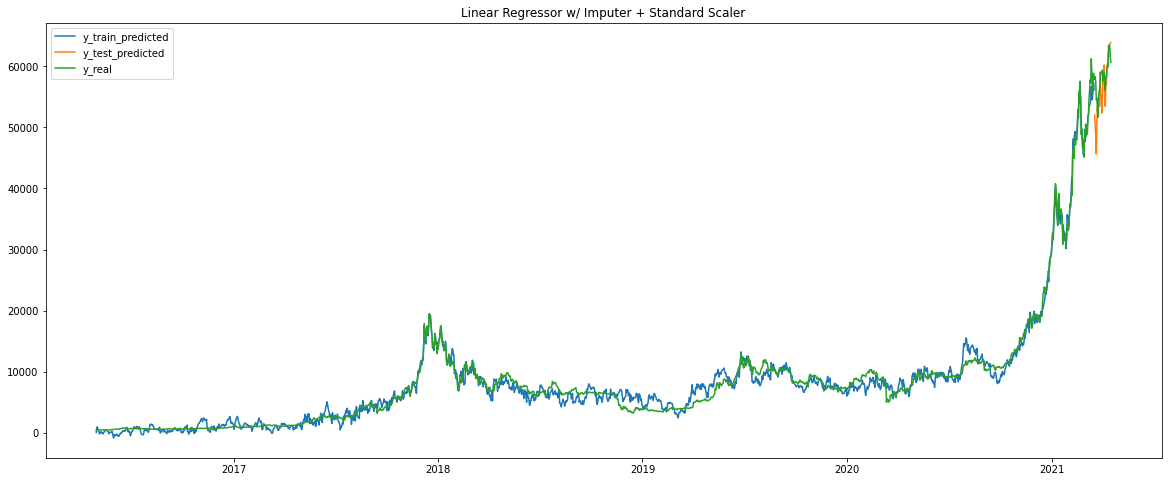

transformed
CPU times: user 10 s, sys: 3.94 s, total: 14 s
Wall time: 8.76 s


In [32]:
%%time

i = 0

n = 5
number_pipeline = automl.rankings['id'][:n].values
pipeline_names = automl.rankings['pipeline_name'][:n].values

for i, run_name in zip(number_pipeline, pipeline_names):

    pipeline_10 = automl.get_pipeline(i)

    take_note_model(pipeline_10, 
                    X_train, 
                    X_test, 
                    y_train, 
                    y_test, 
                    experiment_id=experiment_id,
                    lambs= None,#lmbds,
                    com=com,
                    run_name=run_name,

                    log_lags=True,
                    log_com=True,
                    log_window=True,
                    log_columns_Lags=False,
                    log_columns_RollingMeanAverage=False,
                    log_columns_RollingMeanExponential=False,
                    log_columns_RollingStdAverage=False,
                    log_columns_RollingStdExponential=False,
                    log_lmbds=False,
                    log_feature_import_html=True,
                    log_model=False,
                    log_plot_pred_real=True,
                    log_plot_pred_trans=True
                   )

## Deleting trend